### Imports

In [1]:
import arcgis
from arcgis.gis import GIS
from ipywidgets import Layout
from PIL import Image
from keras.preprocessing import image
from keras.models import load_model, model_from_json
from keras import optimizers, regularizers, models, layers
import requests
from io import BytesIO
from urllib.parse import urlencode
from os import listdir, remove, mkdir
from os.path import join, exists, expanduser, isdir
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from file_utils import make_dir_helper, is_jpeg, delete_dir_helper, delete_dir_files_helper

Using TensorFlow backend.


In [2]:
arcgis.__version__

'1.2.0'

### Path Constants

In [3]:
PROJECT_DIR = join(expanduser('~'),'desktop','Esri Project');
MAP_NAME = 'map.jpg'
MAP_DIR = join(PROJECT_DIR, 'maps')
SLICED_DIR = join(MAP_DIR, 'sliced')
TEMP_SLICED_DIR = join(MAP_DIR, 'temp sliced')
DATA_DIR = join(PROJECT_DIR, 'original data 3')
MODEL_PATH =  join(expanduser('~'),  PROJECT_DIR, 'models', 'map_multi_model_redlands_1.h5');

In [4]:
classes = [dname for dname in listdir(DATA_DIR) if isdir(join(DATA_DIR, dname))]
overlay_color_options = {
           0 : (255, 255, 0, 0),
           1 : (255, 255, 0, 0),
           2 : (255, 255, 0, 0),
           3 : (255, 255, 0, 100),
           4 : (255, 255, 0, 0),
           5 : (255, 255, 0, 0),
}

### Slice Constants

In [5]:
SLICE_WIDTH, SLICE_HEIGHT = 256, 256
MAP_WIDTH, MAP_HEIGHT = 4096, 4096

In [6]:
gis = GIS()
arc_map = gis.map('redlands')

arc_map.basemap = 'satellite'
arc_map

Widget Javascript not detected.  It may not be installed or enabled properly.


### Download map using the current extent

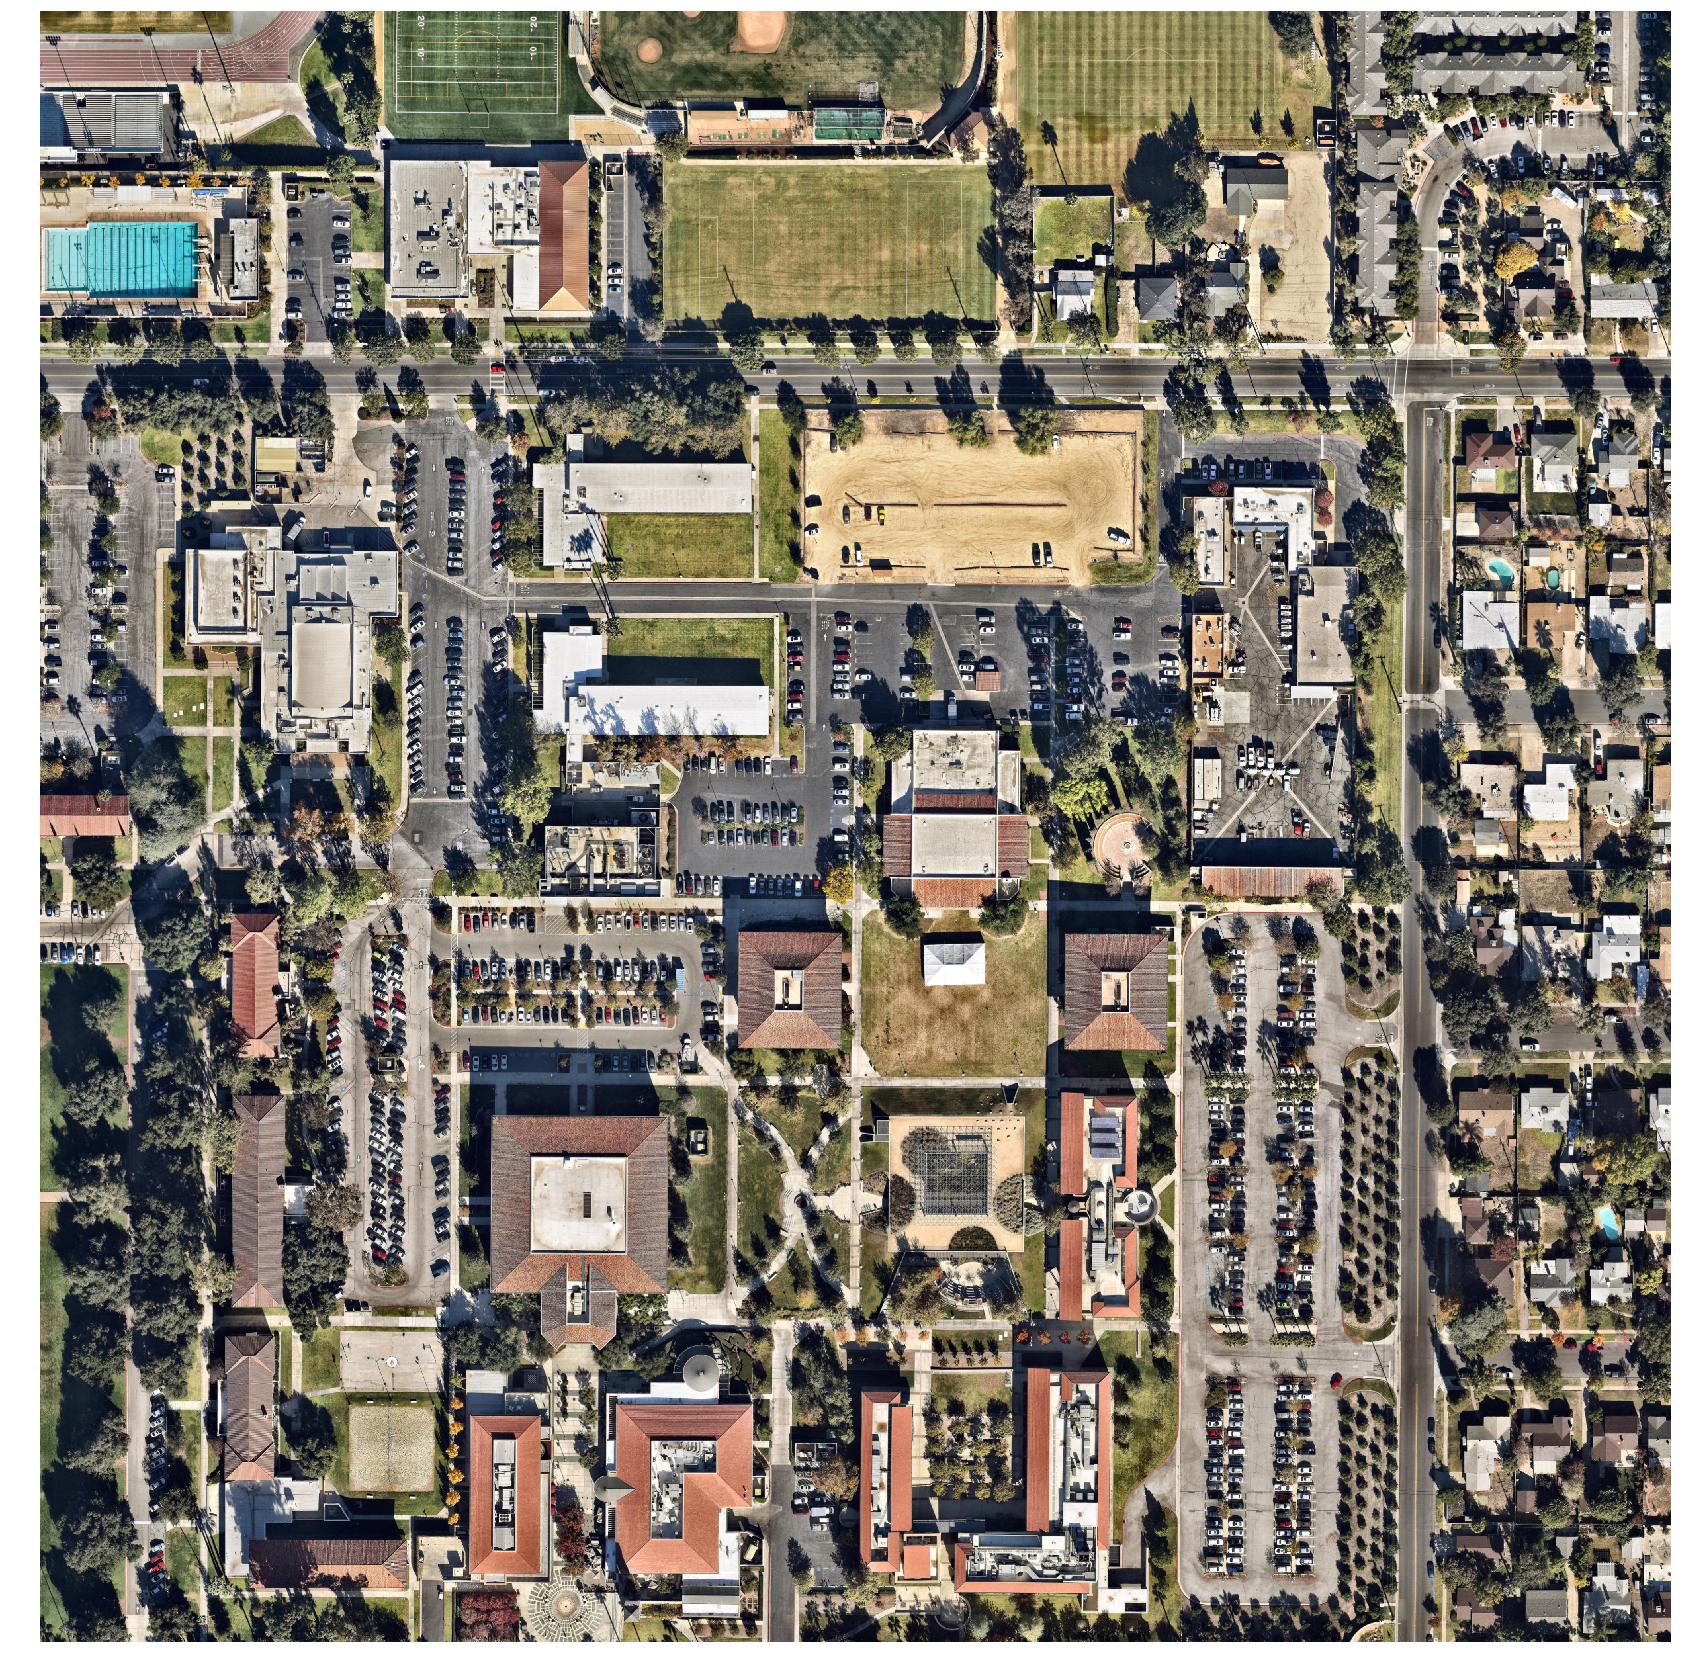

In [7]:
URL = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?'
extent = arc_map.extent

parameters = {
    'bbox':'{},{},{},{}'.format(extent['xmin'], extent['ymin'], extent['xmax'], extent['ymax']),
    'bboxSR':extent['spatialReference']['latestWkid'],
    'size':'{},{}'.format(MAP_WIDTH, MAP_HEIGHT),
    'format':'jpg',
    'f':'image'
}

URL += urlencode(parameters)

MAP_FILE_PATH = join(MAP_DIR, MAP_NAME)

if urlretrieve(URL, MAP_FILE_PATH):
    
    img = image.load_img(MAP_FILE_PATH, target_size=(MAP_HEIGHT, MAP_WIDTH)) 
    plt.figure(figsize=(30, 30)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Slice map into tiles

In [123]:
with Image.open(MAP_FILE_PATH) as im:
    imgwidth, imgheight = im.size
    WIDTH, HEIGHT = 256, 256
    idx = 0
    start_idx = 320 * 19
    for i in range(0, imgheight - SLICE_HEIGHT , SLICE_HEIGHT):
        for j in range(0, imgwidth - SLICE_WIDTH , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                cropped_image = im.crop(box)
                cropped_image.save(join(SLICED_DIR, 'image_{}.jpg'.format(start_idx + idx)), "JPEG", quality=100, optimize=True)
            except:
                traceback.print_exc()
                pass
            idx +=1

### Slice and predict the map

In [ ]:
def predict_class_overlay(img, model):
    
    img_resized = img.resize((128,128), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img_resized)
    img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
    img_tensor /= 255.
    predictions = model.predict(img_tensor)[0]
    max_val = np.amax(predictions)
    max_index = np.argmax(predictions)
    
    return overlay_color_options[max_index]


with Image.open(MAP_FILE_PATH) as im:
    
    imgwidth, imgheight = im.size
    SLICE_WIDTH, SLICE_HEIGHT = 256, 256
    modified_image = Image.new('RGB', im.size)
    idx = 0
    y_offset = 0
    model = load_model(MODEL_PATH)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
    
    for i in range(0, imgheight , SLICE_HEIGHT):
        x_offset = 0
        for j in range(0, imgwidth , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                 
                cropped_image = im.crop(box)
                if idx == 0:
                    overlay_color = predict_class_overlay(cropped_image, model)
                else:
                    overlay_color = (255, 255, 0, 60)
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)
                cropped_image.paste(overlay, (0, 0), overlay)
                # cropped_image.save(join(TEMP_SLICED_DIR, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)
                
                modified_image.paste(cropped_image, (x_offset, y_offset))
                x_offset = x_offset + SLICE_WIDTH
                
            except:
                traceback.print_exc()
                pass
            idx +=1
        y_offset = y_offset + SLICE_HEIGHT
    modified_image.save(join(MAP_DIR, 'modified_map.jpg'), "JPEG", quality=100, optimize=True)

### Predict slices based on model

In [ ]:
image_size = 256

model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
model.summary()

fnames = [fname for fname in listdir(data_dir) if is_jpeg(fname)]
print(fnames)

for idx, fname in enumerate(fnames):

    img_path = join(data_dir, fname)

    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    prediction = model.predict(x)[0]
    max_index = np.argmax(prediction)
    max_val = np.amax(prediction)

    pred_class = class_names[max_index]
    pred_class_dir = join(pred_dir, pred_class)
    make_dir_helper(pred_class_dir)

    img.save(join(pred_class_dir, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)